In [21]:
import pandas as pd
import numpy as np

import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVC

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
all_data = pd.read_csv("../output_files/physics_pairs_data.csv")
pred_tfidf_val = pd.read_csv("data/predicted_prereq.csv")
rank_val = pd.read_csv("data/concept_rank.csv")

In [3]:
all_data["tfidf"] = pred_tfidf_val["wiki_tfidf_score"].to_numpy().ravel()

In [4]:
concept_rank = {}

for i in range(rank_val.shape[0]):
    concept = rank_val[["concept"]].iloc[i].values[0]
    rank = rank_val[["rank"]].iloc[i].values[0]
    concept_rank[concept] = rank

In [5]:
def rank_score(c1, c2):
    r1 = int(concept_rank[c1])
    r2 = int(concept_rank[c2])
    if r1 <= r2:
        return 1
    else:
        return 0

In [6]:
pred_rank = []
for i in range(all_data.shape[0]):
    topic_a = all_data[["topic_a"]].iloc[i].values[0]
    topic_b = all_data[["topic_b"]].iloc[i].values[0]
    rank = rank_score(topic_a, topic_b)
    pred_rank.append(rank)

In [7]:
all_data["rank"] = pred_rank

In [8]:
all_data

,Unnamed: 0,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f33,f34,f35,f36,f37,relation,topic_a,topic_b,tfidf,rank
0,0,321.0,190.0,1613.0,197.0,2.0,4.0,19.0,0.0,0.0,...,504.0,87.0,0.000040,0.000086,1.118241e-05,0.0,Magnetic field,Inertial frame of reference,0.000000,0
1,1,36.0,77.0,109.0,101.0,3.0,2.0,4.0,0.0,0.0,...,161.0,21.0,0.000002,0.000002,9.914547e-08,1.0,Gravitational acceleration,Position (vector),0.000000,0
2,2,808.0,495.0,3104.0,2394.0,2.0,3.0,25.0,0.0,0.0,...,1060.0,103.0,-0.000003,-0.000017,1.509753e-05,0.0,Energy,Planet,0.000000,0
3,3,99.0,48.0,96.0,212.0,2.0,4.0,5.0,0.0,0.0,...,128.0,19.0,0.000007,-0.000004,-1.144610e-05,0.0,Mechanical energy,Gravitational field,0.090940,0
4,4,643.0,162.0,9935.0,129.0,1.0,5.0,21.0,0.0,0.0,...,109.0,12.0,0.000095,0.000940,6.710326e-05,0.0,Physics,Electric potential energy,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957,1957,350.0,203.0,4432.0,92.0,3.0,4.0,22.0,0.0,0.0,...,1078.0,139.0,0.000010,0.000172,2.182559e-05,0.0,Mass,Le Sage's theory of gravitation,0.000000,1
1958,1958,321.0,59.0,1613.0,420.0,2.0,3.0,7.0,1.0,0.0,...,104.0,30.0,0.000113,0.000062,7.647945e-06,0.0,Magnetic field,Length,0.511849,0
1959,1959,127.0,48.0,1368.0,269.0,4.0,1.0,11.0,0.0,0.0,...,269.0,28.0,0.000062,0.000055,8.195897e-06,0.0,Voltage,Series and parallel circuits,0.000000,0
1960,1960,643.0,147.0,9935.0,851.0,1.0,4.0,24.0,0.0,0.0,...,224.0,37.0,0.000150,0.000904,5.851008e-05,0.0,Physics,Velocity,0.000000,1


# Data Normalization

In [9]:
df = all_data[["relation", "tfidf", "rank", "f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9",
            "f10", "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19",
            "f20", "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29",
            "f30", "f31", "f32", "f33", "f34", "f35", "f36", "f37"]]

In [10]:
df.corr()

,relation,tfidf,rank,f0,f1,f2,f3,f4,f5,f6,...,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37
relation,1.000000,0.437022,-0.394142,-0.274663,0.323858,-0.201647,0.273093,-0.003634,-0.105155,0.049004,...,0.291870,-0.135859,0.358678,-0.162340,-0.217845,0.195284,0.013843,-0.138730,-0.271796,-0.407061
tfidf,0.437022,1.000000,-0.380882,-0.140150,0.373030,-0.096854,0.390122,0.019012,-0.158779,-0.000312,...,0.193350,-0.060637,0.267601,-0.098862,-0.112031,0.247097,0.025743,-0.194625,-0.292722,-0.437032
rank,-0.394142,-0.380882,1.000000,0.262550,-0.263595,0.246231,-0.240038,-0.038027,0.024653,0.076180,...,-0.184750,0.223924,-0.199709,0.271291,0.151837,-0.191057,0.002943,0.191626,0.274544,0.441246
f0,-0.274663,-0.140150,0.262550,1.000000,-0.068297,0.540906,-0.078357,0.016583,0.047338,0.163870,...,0.004098,0.212847,-0.182716,0.164810,0.816726,-0.027999,0.400360,0.339464,0.318917,0.548772
f1,0.323858,0.373030,-0.263595,-0.068297,1.000000,-0.073316,0.506576,0.072269,-0.032571,0.218096,...,0.207389,0.009823,0.158203,-0.168357,-0.033677,0.814475,0.420446,-0.412019,-0.323748,-0.554653
f2,-0.201647,-0.096854,0.246231,0.540906,-0.073316,1.000000,-0.063400,-0.050681,0.021698,0.009639,...,-0.060710,0.073187,-0.111598,0.051422,0.348096,-0.052346,0.093705,0.238469,0.660178,0.647199
f3,0.273093,0.390122,-0.240038,-0.078357,0.506576,-0.063400,1.000000,0.055981,0.007001,-0.000206,...,0.063773,-0.064093,0.037333,-0.113562,-0.044151,0.316381,0.070732,-0.249888,-0.757114,-0.652273
f4,-0.003634,0.019012,-0.038027,0.016583,0.072269,-0.050681,0.055981,1.000000,0.022369,0.062313,...,0.057540,-0.029286,-0.014453,-0.036761,0.179591,0.063716,0.152876,-0.034541,-0.058944,-0.126162
f5,-0.105155,-0.158779,0.024653,0.047338,-0.032571,0.021698,0.007001,0.022369,1.000000,0.068393,...,-0.007431,0.068858,-0.010075,0.001170,0.045365,0.144542,0.139768,0.004345,-0.016644,0.096153
f6,0.049004,-0.000312,0.076180,0.163870,0.218096,0.009639,-0.000206,0.062313,0.068393,1.000000,...,0.253080,0.272388,0.102653,0.118482,0.110690,0.180274,0.481654,-0.018539,0.013969,0.003824


In [11]:
columns = ["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9",
            "f10", "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19",
            "f20", "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29",
            "f30", "f31", "f32", "f33", "f34", "f35", "f36", "f37", "tfidf", "rank"]

def normalize_array(x):
    x = np.array(x)
    min_x = np.min(x)
    max_x = np.max(x)
    x = (x - min_x)/(max_x - min_x)
    return x


def normalized_df(df):
    X = [normalize_array([df[[col]].values[i][0] for i in range(len(df[[col]]))]) for col in columns]
    X = np.array(X)
    return X.T

In [12]:
X = all_data[["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9",
            "f10", "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19",
            "f20", "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29",
            "f30", "f31", "f32", "f33", "f34", "f35", "f36", "f37", "tfidf", "rank"]]
X = normalized_df(X)

In [31]:
y = all_data[["relation"]].to_numpy().ravel()

In [28]:
X_new = X
X_old = X[:,:-2]

In [16]:
X_train_new, X_test_new, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [19]:
X_train_old = X_train_new[:,:-2]
X_test_old = X_test_new[:,:-2]

# Data Modeling along with our features

In [47]:
def random_forest(x_train, x_test, y_train, y_test):
    rand_forest = RandomForestClassifier(max_depth = 200, random_state=0)
    rand_forest.fit(x_train, y_train)
    y_predict = rand_forest.decision_function(x_test)
    print(y_predict.shape)
    prc = average_precision_score(y_test, y_predict)
#     precision, recall, theta = precision_recall_curve(y_test, y_predict[:,1])
#     disp = plot_precision_recall_curve(rand_forest, x_test, y_test)
    return prc


def logistic_reg(x_train, x_test, y_train, y_test):
    log_reg = LogisticRegression(random_state=0)
    log_reg.fit(x_train, y_train)
    y_predict = log_reg.decision_function(x_test)
    prc = average_precision_score(y_test, y_predict)
    return prc

## Results with incrementnal data (New Features)

In [82]:
train_size = 1373

prc_new = []

k = [i for i in range(1, 101)]

for i in k:
    n = int(np.floor((train_size/100)*i))
    prc = logistic_reg(X_train_new[:n,:], X_test_new, y_train[:n], y_test)
    prc_new.append(prc)

In [84]:
train_size = 1373

prc_old = []

k = [i for i in range(1, 101)]

for i in k:
    n = int(np.floor((train_size/100)*i))
    prc = logistic_reg(X_train_old[:n,:], X_test_old, y_train[:n], y_test)
    prc_old.append(prc)

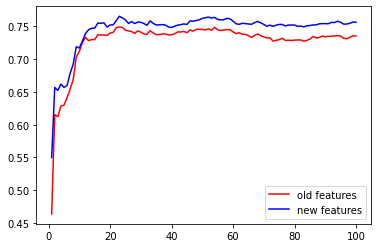

In [85]:
plt.plot(k, prc_old, 'r', label = "old features")
plt.plot(k, prc_new, 'b', label = "new features")
plt.legend(loc='best')
plt.show()

## Finding best Features with New Features

In [68]:
k_new = X_train_new.shape[1]

K = []
prc_new = []

for k in range(2, 35):
    X_temp = SelectKBest(chi2, k = k).fit_transform(X_new, y)
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size = 0.3, random_state = 0)
    prc = logistic_reg(X_train, X_test, y_train, y_test)
    prc_new.append(prc)
    K.append(k)

In [75]:
prc_new

[0.5155349529791103,
 0.6217033670313803,
 0.6272217238168789,
 0.6642367706636737,
 0.674990331655724,
 0.6898154071236005,
 0.7056680134321693,
 0.7091116823633112,
 0.7161380054479791,
 0.7215409060859181,
 0.7222830635616375,
 0.7201649633494521,
 0.7185394434402899,
 0.7231303901070358,
 0.727805380568321,
 0.7277048086648061,
 0.7278396867446179,
 0.7274345711494742,
 0.7303339491920313,
 0.7302753218787392,
 0.730568547417605,
 0.7308465853681286,
 0.731520389907006,
 0.7355888200365491,
 0.7346460741633971,
 0.7375089313613736,
 0.7398512894334853,
 0.7403041671316967,
 0.7404712791226378,
 0.7401807086804792,
 0.7471490159398076,
 0.7463171621531283,
 0.7472093035601656]

## Finding best features in old features

In [71]:
k_old = X_old.shape[1]

K = []
prc_old = []

for k in range(2, 35):
    X_temp = SelectKBest(chi2, k = k).fit_transform(X_old, y)
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size = 0.3, random_state = 0)
    prc = logistic_reg(X_train, X_test, y_train, y_test)
    prc_old.append(prc)
    K.append(k)

In [72]:
prc_old

[0.41358509176166225,
 0.5854590047570032,
 0.6011872221728587,
 0.6621023964471572,
 0.6656554124640559,
 0.6654976306357604,
 0.6833416536304513,
 0.6944496851339642,
 0.6978435363338642,
 0.6949815582370699,
 0.6948658596227674,
 0.7054692681572611,
 0.7115425872613577,
 0.7113499654031246,
 0.7109910396250531,
 0.7102794100169263,
 0.7132775984398407,
 0.7129506897457041,
 0.7145252887600153,
 0.7145220680807985,
 0.7145413136698349,
 0.7184265082195419,
 0.7183675892832904,
 0.719855461321233,
 0.7202384109803123,
 0.7201465565038656,
 0.7201962483020091,
 0.7196868859018242,
 0.7267351838768266,
 0.7276405356760737,
 0.726617990980601,
 0.7266746098217337,
 0.72688538544332]

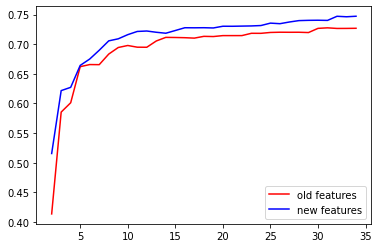

In [78]:
plt.plot(K, prc_old, 'r', label = "old features")
plt.plot(K, prc_new, 'b', label = "new features")
plt.legend(loc='best')
plt.show()